In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
url = '/content/drive/MyDrive/SoftCom/'

In [6]:
dataset_A = url + 'Dataset A.zip'
with ZipFile(dataset_A, 'r') as zip:
  zip.extractall()

In [7]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-a.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(19702, 2)


,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [8]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-a')

In [9]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [10]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  19702


# **Base Parameters**

In [11]:
batch_size = 75
num_iters = 20000
input_dim = 28*28
num_hidden = 50
output_dim = 10

learning_rate = 0.0275

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

76


In [12]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:211
Test dataloader:53


In [13]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        # self.linear_3 = nn.Linear(num_hidden, num_hidden)
        # self.relu_3 = nn.ReLU()
 
        # self.linear_4 = nn.Linear(num_hidden, num_hidden)
        # self.relu_4 = nn.ReLU()
 
 
        # self.linear_5= nn.Linear(num_hidden, num_hidden)
        # self.relu_5= nn.ReLU()
 
        # self.linear_6 = nn.Linear(num_hidden, num_hidden)
        # self.relu_6 = nn.ReLU()
      
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        # out  = self.linear_3(out)
        # out = self.relu_3(out)
 
        # out  = self.linear_4(out)
        # out = self.relu_4(out)
      
        # out  = self.linear_5(out)
        # out = self.relu_5(out)
 
        # out  = self.linear_6(out)
        # out = self.relu_6(out)
       
        
        probas  = self.linear_out(out)
        return probas

In [14]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=50, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=50, out_features=50, bias=True)
  (relu_2): ReLU()
  (linear_out): Linear(in_features=50, out_features=10, bias=True)
)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [16]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Iteration: 500. Loss: 2.2814741134643555. Accuracy: 12.106598984771574
Epoch:  4
Epoch:  5
Iteration: 1000. Loss: 2.2331786155700684. Accuracy: 22.563451776649746
Epoch:  6
Epoch:  7
Epoch:  8
Iteration: 1500. Loss: 2.061297655105591. Accuracy: 28.299492385786802
Epoch:  9
Epoch:  10
Iteration: 2000. Loss: 2.305330514907837. Accuracy: 38.60406091370558
Epoch:  11
Epoch:  12
Iteration: 2500. Loss: 1.9855877161026. Accuracy: 26.14213197969543
Epoch:  13
Epoch:  14
Epoch:  15
Iteration: 3000. Loss: 1.6746141910552979. Accuracy: 22.512690355329948
Epoch:  16
Epoch:  17
Iteration: 3500. Loss: 1.5437124967575073. Accuracy: 44.16243654822335
Epoch:  18
Epoch:  19
Iteration: 4000. Loss: 1.3930237293243408. Accuracy: 52.944162436548226
Epoch:  20
Epoch:  21
Epoch:  22
Iteration: 4500. Loss: 1.6570351123809814. Accuracy: 38.223350253807105
Epoch:  23
Epoch:  24
Iteration: 5000. Loss: 1.4682916402816772. Accuracy: 53.3756345177665
Epoch:  25
Epoch:  26
Epoch:  27
Ite

In [17]:
torch.save(model.state_dict(), '/content/drive/MyDrive/SoftCom/Model77.pkl')

[2.3008804321289062, 2.299354076385498, 2.2994017601013184, 2.2999446392059326, 2.2894272804260254, 2.276526689529419, 2.259146213531494, 2.2070720195770264, 2.2023696899414062, 2.047470808029175, 2.341451406478882, 1.9840035438537598, 1.9165465831756592, 1.835781455039978, 1.9555796384811401, 1.638861060142517, 1.6599607467651367, 1.5662415027618408, 1.5246529579162598, 1.3926713466644287, 1.3233355283737183, 1.2889811992645264, 1.65302574634552, 1.561439871788025, 0.996238112449646, 1.1965168714523315, 1.3574451208114624, 1.0610264539718628, 0.9725964069366455, 0.9840724468231201, 0.6965720057487488, 1.1844390630722046]


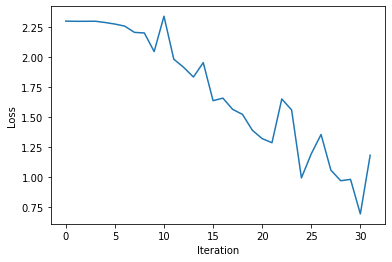

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()